## Imports and Setup

In [2]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import data_utils
import config_utils
import pred_utils
import model_utils
import cnn_utils
import post_utils

%load_ext autoreload
%autoreload 2

## Data Configurations

In [21]:
iso_code = "SEN"
cwd = os.path.dirname(os.getcwd())

data_config_file = os.path.join(cwd, "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

# Model configuration file
model_config_file = os.path.join(cwd, f"configs/cnn_configs/satlas-aerial_swinb_si_01.yaml")
model_config = config_utils.load_config(model_config_file)
model_config["iso_codes"] = [iso_code]
classes = {1: model_config["pos_class"], 0: model_config["neg_class"]}

# Model file
exp_dir = os.path.join(cwd, model_config["exp_dir"], model_config["project"], f"{iso_code}_{model_config['config_name']}")
model_file = os.path.join(exp_dir, f"{iso_code}_{model_config['config_name']}.pth")
model = pred_utils.load_cnn(model_config, classes, model_file)

## Load Training and Test Data

In [4]:
data = model_utils.load_data(model_config, attributes=["rurban", "iso"], verbose=False)
filepaths = data_utils.get_image_filepaths(model_config, data)
data[(data['class'] == 'school') & (data['rurban'] == 'urban')].sample(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
5601,UNICEF-SEN-SCHOOL-00008671,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE SEUNE WOLOF,571c896b-2b95-372c-ad0a-ec88ec650d1f,0,0.0,school,21,urban,test,POINT (-1673951.939 1822325.923)
5960,UNICEF-SEN-SCHOOL-00009248,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE KANEL2,adbd6b66-448d-3367-ac4d-bb026a781dbf,0,0.0,school,23,urban,test,POINT (-1290440.253 1906893.516)
4624,UNICEF-SEN-SCHOOL-00007160,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE GASSANE,7aac11dc-ec4c-3250-adec-b956ba22b733,0,0.0,school,23,urban,train,POINT (-1501104.075 1824685.158)


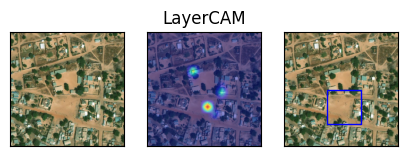

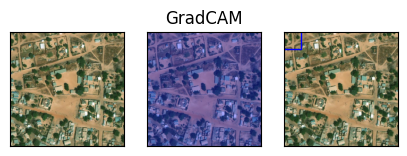

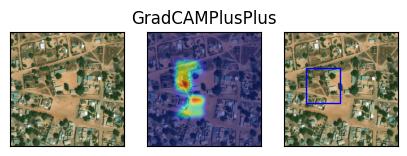

In [24]:
index = 4624
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

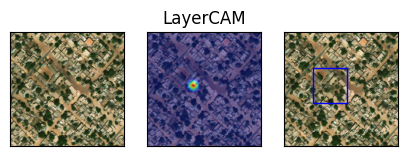

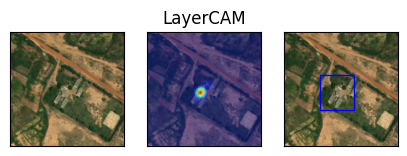

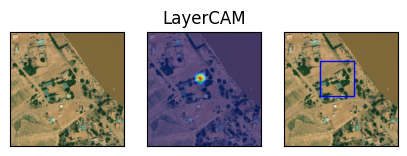

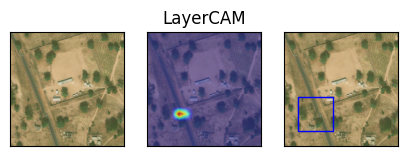

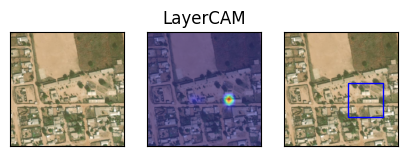

In [25]:
subdata = data[(data['class'] == 'school')]
model = pred_utils.compare_cams_random(subdata, filepaths, model_config, classes, model_file, verbose=False);

## Load Model Outputs

In [46]:
shapename = "Fatick"
name = f"{iso_code}_{shapename}"
sat_dir = os.path.join(cwd, "output", iso_code, "images", shapename)
data = post_utils.load_data(iso_code, data_config, model_config, sum_threshold=5, source="pred")
filepaths = data_utils.get_image_filepaths(model_config, data, in_dir=sat_dir)
data.sample(3)

,prob,UID,sum,group,geometry,ADM1,ADM2,ADM3,PUID
7993,0.890556,1120249,12.0,14407,"POLYGON ((-1537397.068 1811134.995, -1537397.0...",Saint Louis,Podor,Salde,Podor_1120249
2388,0.967682,407497,41.0,5483,"POLYGON ((-1493789.455 1777819.605, -1493789.4...",Matam,Matam,Ogo,Matam_407497
8141,0.883113,43197,21.0,7566,"POLYGON ((-1842342.325 1402052.936, -1842342.3...",Ziguinchor,Oussouye,Loudia Wolof,Oussouye_43197


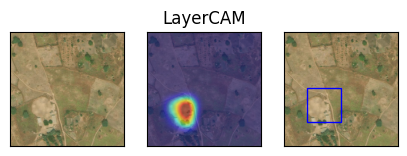

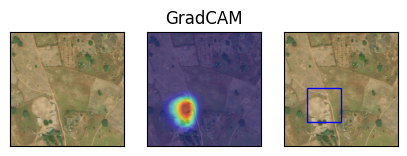

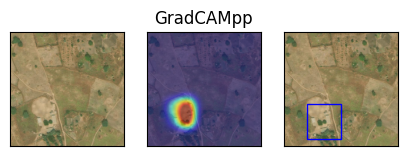

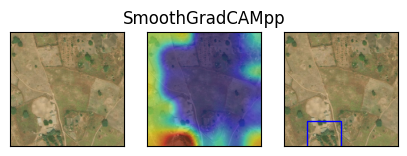

In [43]:
index = data[data.PUID == 'Fatick_29335'].index[0]
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

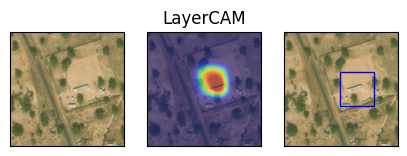

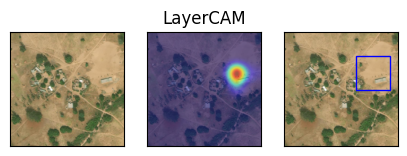

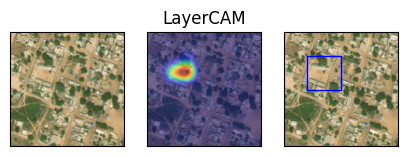

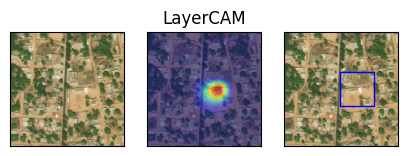

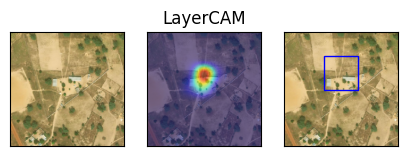

In [48]:
subdata = data[(data["ADM2"] == shapename) & (data['prob'] > 0.9)]
pred_utils.compare_cams_random(subdata, filepaths, model_config, classes, model_file, verbose=False)

## Georeference Images

In [ ]:
sat_config_file = os.path.join(cwd, 'configs/sat_configs/sat_config_500x500_60cm.yaml')
sat_config = config_utils.load_config(sat_config_file)
geotiff_dir = data_utils._makedir(os.path.join("output", iso_code, "geotiff", shapename))
pred_utils.georeference_images(data[data["pred"] == "school"], sat_config, sat_dir, geotiff_dir)

## Generate Bounding Boxes from CAMs

In [ ]:
from torchcam.methods import LayerCAM
model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
cam_extractor = LayerCAM(model)
results = pred_utils.generate_cam_bboxes(
    data[data['pred'] == 'school'].reset_index(drop=True), 
    model_config,
    geotiff_dir, 
    model, 
    cam_extractor
)
out_dir = os.path.join(cwd, "output", iso_code, "results")
filename = f"{iso_code}_{shapename}_{model_config['model']}_cam.gpkg"
out_file = os.path.join(out_dir, filename)
results.to_file(out_file, driver="GPKG")